In [2]:
# Analysis on energy indicators,gdp and scimago journal & country rank datas

# import packages
import pandas as pd
import numpy as np
import re

# read data
energy = pd.read_excel('Energy Indicators.xls',skiprows=17,skipfooter=38,usecols=[2,3,4,5]).rename(columns={'Unnamed: 2':'Country','Petajoules':'Energy Supply','Gigajoules':'Energy Supply per Capita','%':'% Renewable'})
energy.replace({'...': np.nan},inplace=True)
energy['Energy Supply'] *= (10 ** 6)
sel = []
for country in energy['Country']:
    sel.append(re.sub('\d+|\(.*','',country).strip())
energy['Country'] = sel
energy.replace({'Country':{'Republic of Korea':'South Korea',
                          'United States of America':'United States',
                            'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
                            'China, Hong Kong Special Administrative Region':'Hong Kong'}},inplace=True)
    
GDP = pd.read_csv('world_bank.csv',skiprows=4)
GDP.rename(columns={'Country Name':'Country'},inplace=True)
GDP.drop(['Indicator Name','Indicator Code'],axis=1,inplace=True)
GDP.replace({'Country':{'Korea, Rep.':'South Korea',
                        'Iran, Islamic Rep.':'Iran',
                        'Hong Kong SAR, China':'Hong Kong'}},inplace=True)
     
ScimEn = pd.read_excel('scimagojr-3.xlsx')
    
data1 = pd.merge(energy,GDP,on='Country',how='inner')
data2 = pd.merge(data1,ScimEn,on='Country',how='inner')
  
Top15 = data2[data2['Rank'].isin([r for r in range(1,16)])]
Top15 = Top15.loc[:,[c for c in Top15.columns if (c.isdigit() and int(c)>=2006) or (not c.isdigit())]]
del Top15['Country Code']
Top15.set_index('Country',inplace=True)
print(Top15.head())

           Energy Supply  Energy Supply per Capita  % Renewable          2006  \
Country                                                                         
Australia   5.386000e+09                     231.0     11.81081  1.021939e+12   
Brazil      1.214900e+10                      59.0     69.64803  1.845080e+12   
Canada      1.043100e+10                     296.0     61.94543  1.564469e+12   
China       1.271910e+11                      93.0     19.75491  3.992331e+12   
France      1.059700e+10                     166.0     17.02028  2.607840e+12   

                   2007          2008          2009          2010  \
Country                                                             
Australia  1.060340e+12  1.099644e+12  1.119654e+12  1.142251e+12   
Brazil     1.957118e+12  2.056809e+12  2.054215e+12  2.208872e+12   
Canada     1.596740e+12  1.612713e+12  1.565145e+12  1.613406e+12   
China      4.559041e+12  4.997775e+12  5.459247e+12  6.039659e+12   
France     2.66942

In [3]:
# average GDP over the last 10 years for each country
avgGDP1 = Top15.loc[:,[c for c in Top15.columns if c.isdigit() and int(c)>=2006]]
avgGDP1['avgGDP'] = avgGDP1.mean(axis=1,skipna=True)
avgGDP1.sort_values('avgGDP',ascending=False,inplace=True)
print(avgGDP1['avgGDP'])

Country
United States         1.536434e+13
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
United Kingdom        2.487907e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                  4.441558e+11
Name: avgGDP, dtype: float64


In [4]:
# by how much had the GDP changed over the 10 year span for the country with say, the 6th largest average GDP
avgGDP = Top15.loc[:,[c for c in Top15.columns if c.isdigit() and int(c)>=2006]]
avgGDP = avgGDP.mean(axis=1)
print(Top15.loc[avgGDP.nlargest(6).idxmin(),'2015'] - Top15.loc[avgGDP.nlargest(6).idxmin(),'2006'])

246702696075.3999


In [5]:
# mean Energy Supply per Capita
print(Top15['Energy Supply per Capita'].mean())

157.6


In [8]:
# country that has the maximum % Renewable and the value
print(Top15['% Renewable'].idxmax(),Top15['% Renewable'].max())

Brazil 69.64803


In [9]:
# maximum ratio value of selef-citations to citations and country with the highest ratio
Top15['Ratio'] = Top15['Self-citations'].div(Top15['Citations'])
print(Top15['Ratio'].idxmax(),Top15['Ratio'].max())

China 0.6893126179389422


In [10]:
# third most populous country
Top15['Pop Estimate'] = Top15['Energy Supply'].div(Top15['Energy Supply per Capita'])
print(Top15['Pop Estimate'].nlargest(3).idxmin())

United States


In [11]:
# correlation between the number of citable documents per capita and the energy supply per capita?
Top15['Citable documents per person'] = Top15['Citable documents'].div(Top15['Pop Estimate'])
print(Top15['Citable documents per person'].corr(Top15['Energy Supply per Capita']))

0.7940010435442942


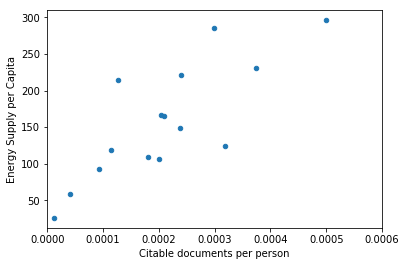

In [16]:
import matplotlib as plt
%matplotlib inline
    
Top15.plot(x='Citable documents per person', y='Energy Supply per Capita', kind='scatter', xlim=[0, 0.0006])

In [12]:
# create a new column with a 1 if the country's % Renewable value is at or above the median for all countries in the top 15, 
# and a 0 if the country's % Renewable value is below the median.
d = {False:0,True:1}
Top15['HighRenew'] = Top15['% Renewable'] >= Top15['% Renewable'].median()
Top15['HighRenew'] = Top15['HighRenew'].map(d)
Top15.sort_values('Rank',inplace=True)
print(Top15['HighRenew'])

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: HighRenew, dtype: int64


In [13]:
# create dictionary to group the Countries by Continent, then display the sample size (the number of countries in each 
# continent bin), and the sum, mean, and std deviation for the estimated population of each country.
ContinentDict = {'China':'Asia', 
                'United States':'North America', 
                'Japan':'Asia', 
                'United Kingdom':'Europe', 
                'Russian Federation':'Europe', 
                'Canada':'North America', 
                'Germany':'Europe', 
                'India':'Asia',
                'France':'Europe', 
                'South Korea':'Asia', 
                'Italy':'Europe', 
                'Spain':'Europe', 
                'Iran':'Asia',
                'Australia':'Australia', 
                'Brazil':'South America'}
Top15['Continent'] = Top15.index.to_series().map(ContinentDict)
Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
a = Top15['Continent'].value_counts().rename('size')
b = Top15.groupby('Continent')['PopEst'].sum().rename('sum')
c = Top15.groupby('Continent')['PopEst'].apply(np.mean).rename('mean')
d = Top15.groupby('Continent')['PopEst'].apply(np.std).rename('std')
df = pd.DataFrame([a,b,c,d]).T
df.index.name = 'Continent'
print(df)

               size           sum          mean           std
Continent                                                    
Europe          6.0  4.579297e+08  7.632161e+07  3.162885e+07
Asia            5.0  2.898666e+09  5.797333e+08  6.074036e+08
North America   2.0  3.528552e+08  1.764276e+08  1.411878e+08
South America   1.0  2.059153e+08  2.059153e+08  0.000000e+00
Australia       1.0  2.331602e+07  2.331602e+07  0.000000e+00


In [14]:
# cut % Renewable into 5 bins. group Top15 by the Continent and % Renewable bins; how many countries are in each group
Top15.reset_index(inplace=True)
Top15['% Renewable'] = pd.cut(Top15['% Renewable'],5)
print(Top15.groupby(['Continent','% Renewable'])['Country'].count())

Continent      % Renewable     
Asia           (2.212, 15.753]     4
               (15.753, 29.227]    1
Australia      (2.212, 15.753]     1
Europe         (2.212, 15.753]     1
               (15.753, 29.227]    3
               (29.227, 42.701]    2
North America  (2.212, 15.753]     1
               (56.174, 69.648]    1
South America  (56.174, 69.648]    1
Name: Country, dtype: int64
